In [1]:
import os.path
import sys

import keras.metrics
from keras import callbacks, models, metrics
from datahandler.constants import all_features, data_version, acc_features, tensorboard_dir, location_labels, mag_features
from datahandler.data_preprocessing import get_train_test_data, load_data_v3
from models.log_writer import LogWriter
from model.lstm import make_lstm_model_v1
from model.transformer import make_transformer_model_v1, make_transformer_model_v2
from model.cnn import make_cnn_model_v1, make_cnn_model_v2
import matplotlib.pyplot as plt
from utils import print_line_divider
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
from datahandler.data_preprocessing_from_jupyter import load_train_test_data_raw_normalized,load_train_test_data_added_features_normalized, load_train_test_data_added_features_pca
from audio.audio import play_training_is_complete
from sklearn.metrics import classification_report
import time

In [2]:
# DATA Loader
print_line_divider()
print("Preparing data...")
# x_train, y_train, x_test, y_test = get_train_test_data(supported_features, window_time_in_seconds, window_size)
# x_train, y_train, x_test, y_test = load_data_v3(
#     features = supported_features,
#     window_time_in_seconds = window_time_in_seconds,
#     window_size = window_size
# )
x_train, y_train, x_test, y_test = load_train_test_data_raw_normalized(selected_features=all_features)
print("Train data shape: " + str(x_train.shape) + " | Train label shape: " + str(y_train.shape))
print("Test data shape: " + str(x_test.shape) + " | Test label shape: " + str(y_test.shape))
print_line_divider()


****************************************************
Preparing data...
Loading from file: /Users/duc.letran/Desktop/FINAL PROJECT/context_transformer/data/v4/mix_labeled/mm5_datacollection.csv (1/25)
Loading from file: /Users/duc.letran/Desktop/FINAL PROJECT/context_transformer/data/v4/mix_labeled/pp1_datacollection.csv (2/25)
Loading from file: /Users/duc.letran/Desktop/FINAL PROJECT/context_transformer/data/v4/mix_labeled/ds2_datacollection.csv (3/25)
Loading from file: /Users/duc.letran/Desktop/FINAL PROJECT/context_transformer/data/v4/mix_labeled/ds1_datacollection.csv (4/25)
Loading from file: /Users/duc.letran/Desktop/FINAL PROJECT/context_transformer/data/v4/mix_labeled/tt4_datacollection.csv (5/25)
Loading from file: /Users/duc.letran/Desktop/FINAL PROJECT/context_transformer/data/v4/mix_labeled/os4_datacollection.csv (6/25)
Loading from file: /Users/duc.letran/Desktop/FINAL PROJECT/context_transformer/data/v4/mix_labeled/pp2_datacollection.csv (7/25)
Loading from file: /Users/

In [94]:
# LOGGING CONFIGURATION
enabled_log = True
enabled_tensor_board = True
log_writer = LogWriter(enabled_log)

In [95]:
# TRAINING CONFIGURATION
print("STARTING THE TRAINING PROCESS")
SAVED_BEST_MODEL = "model/best_model.h5"
window_time_in_seconds = 2
window_size = 40
epochs = 1000
batch_size = 32
validation_split = 15 / 85
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.005,
    name="Adam",
)
loss_function = "sparse_categorical_crossentropy"
supported_features = all_features

STARTING THE TRAINING PROCESS


In [96]:
log_writer.write("Configuration", line_divider=True)
log_writer.write(
    f"""Window size: {window_size}
Window time in second: {window_time_in_seconds}
Maximum number of epochs: {epochs}
Batch size: {batch_size}
Validation split: {validation_split}
Optimizer: {optimizer}
Loss function: {loss_function}"""
)
log_writer.write("Data", line_divider=True)
log_writer.write("Data loaded from version " + data_version)
log_writer.write(
    f"""Data training shape: ${x_train.shape}
Data testing shape: ${x_test.shape}"""
)

In [97]:
def check_distribution(labels_list, set_name):
    label_count_dict = {}
    for label_ind in labels_list:
        if label_ind in label_count_dict.keys():
            label_count_dict[label_ind] += 1
        else:
            label_count_dict[label_ind] = 1

    print_line_divider()
    print("Distribution for set " + set_name + "\n")
    for key in label_count_dict:
        key = int(key)
        print(location_labels[key] + " count is " + str(label_count_dict[key]))


check_distribution(y_train, "Training set")
check_distribution(y_test, "Testing set")

****************************************************
Distribution for set Training set

holdinginhand count is 1280
insidethepantpocket count is 1298
calling count is 1291
beingusedinhand count is 1281
insidethebag count is 1265
****************************************************
Distribution for set Testing set

holdinginhand count is 220
insidethepantpocket count is 205
calling count is 210
beingusedinhand count is 220
insidethebag count is 235


In [98]:
if len(x_train.shape) == 2:
    input_shape = (x_train.shape[1], 1)
else:
    input_shape = x_train.shape[1:]
print("Input shape: " + str(input_shape))

Input shape: (40, 9)


In [99]:
# SETTING UP THE MODEL
# model_name, model = make_cnn_model_v1(input_shape=input_shape)
# model_name, model = make_lstm_model_v1(input_shape=input_shape)
model_name, model = make_transformer_model_v1(
    input_shape=input_shape,
    head_size=64,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=2,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)
# model_name, model = make_transformer_model_v2(input_shape=input_shape)
print("Model Summary:")
stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
short_model_summary = "\n".join(stringlist)
print(short_model_summary)
print(print_line_divider())

Model Summary:
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 40, 9)]      0           []                               
                                                                                                  
 layer_normalization_10 (LayerN  (None, 40, 9)       18          ['input_6[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_5 (MultiH  (None, 40, 9)       9993        ['layer_normalization_10[0][0]', 
 eadAttention)                                                    'layer_normalization_10[0][0]'] 
                                                                             

In [100]:
# LOGGING THE MODEL
log_writer.write("Model", line_divider=True)
log_writer.write("Model name: " + model_name)
log_writer.write(short_model_summary)

In [ ]:
# MODELS CALLBACK AND SETUP
callback_list = [
    callbacks.ModelCheckpoint(SAVED_BEST_MODEL, save_best_only=True, monitor="val_loss"),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=50, min_lr=0.0001),
    callbacks.EarlyStopping(monitor="val_loss", patience=500, verbose=1)
]
if enabled_tensor_board:
    callback_list.append(callbacks.TensorBoard(log_dir=tensorboard_dir, histogram_freq=1))
if log_writer.enabled:
    callback_list.append(
        callbacks.ModelCheckpoint(log_writer.base_folder + "/model.h5", save_best_only=True, monitor="val_loss")
    )
model.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=["sparse_categorical_accuracy"],
)

In [102]:
# TRAINING
print_line_divider()
print("Starting to train...")

start_time = time.time()
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callback_list,
    validation_split=validation_split,
    verbose=1,
    shuffle=True
)
end_time = time.time()
training_time = end_time - start_time
print("Total training time in seconds: " + str(training_time))
print("Highest validation accuracy: ", max(history.history['val_sparse_categorical_accuracy']))
log_writer.write("Result", line_divider=True)
log_writer.write("Training time: " + str(end_time - start_time) + " seconds.")
log_writer.write("Highest validation accuracy: " + str(max(history.history['val_sparse_categorical_accuracy'])))
play_training_is_complete()

****************************************************
Starting to train...
Epoch 1/1000
166/166 [==============================] - 16s 87ms/step - loss: 1.1017 - sparse_categorical_accuracy: 0.4962 - val_loss: 1.3483 - val_sparse_categorical_accuracy: 0.3831 - lr: 0.0050
Epoch 2/1000
166/166 [==============================] - 12s 75ms/step - loss: 0.7694 - sparse_categorical_accuracy: 0.6817 - val_loss: 0.8289 - val_sparse_categorical_accuracy: 0.6169 - lr: 0.0050
Epoch 3/1000
166/166 [==============================] - 12s 71ms/step - loss: 0.6575 - sparse_categorical_accuracy: 0.7370 - val_loss: 0.5990 - val_sparse_categorical_accuracy: 0.7502 - lr: 0.0050
Epoch 4/1000
166/166 [==============================] - 12s 73ms/step - loss: 0.5325 - sparse_categorical_accuracy: 0.8097 - val_loss: 0.5359 - val_sparse_categorical_accuracy: 0.7996 - lr: 0.0050
Epoch 5/1000
166/166 [==============================] - 13s 78ms/step - loss: 0.4734 - sparse_categorical_accuracy: 0.8359 - val_loss: 0.4

Input #0, wav, from '/var/folders/ph/8yv0q18n4mb1439tnf3rzcf40000gp/T/tmpkyr8nwxk.wav':
  Duration: 00:00:02.27, bitrate: 705 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s16, 705 kb/s


In [103]:
if log_writer.enabled:
    model.save(log_writer.base_folder + "/model_last.h5")

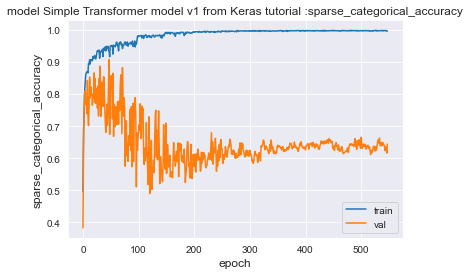

In [104]:
# PLOTTING
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + model_name + " :" + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
if log_writer.enabled:
    plt.savefig(os.path.join(log_writer.base_folder, "Validation progress.png"))
plt.show()
plt.close()

35/35 [==============================] - 1s 24ms/step - loss: 1.1281 - sparse_categorical_accuracy: 0.7211
****************************************************
Test accuracy 0.721100926399231
Test loss 1.128060221672058
Metrics report: 
              precision    recall  f1-score   support

         0.0       0.57      0.76      0.65       220
         1.0       0.82      1.00      0.90       235
         2.0       1.00      0.00      0.01       210
         3.0       0.88      0.97      0.92       205
         4.0       0.65      0.84      0.74       220

    accuracy                           0.72      1090
   macro avg       0.78      0.71      0.64      1090
weighted avg       0.78      0.72      0.65      1090



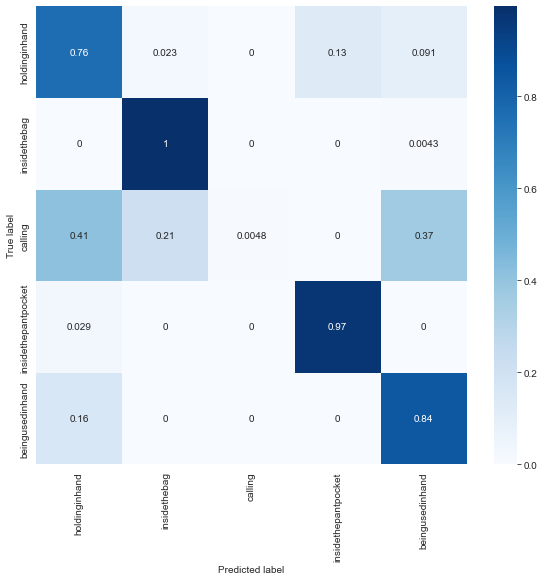

In [105]:
# EVALUATION
test_loss, test_acc = model.evaluate(x_test, y_test)
print_line_divider()
print("Test accuracy", test_acc)
print("Test loss", test_loss)

# Accuracy based on different labels
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
metrics_report = classification_report(y_test, y_pred)
print("Metrics report: ")
print(metrics_report)

con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=4)
con_mat_df = pd.DataFrame(con_mat_norm, index=location_labels, columns=location_labels)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
if log_writer.enabled:
    plt.savefig(os.path.join(log_writer.base_folder, "Accuracy.png"))
plt.show()
plt.close()


In [106]:
log_writer.write("Test evaluation", line_divider=True)
log_writer.write("Test accuracy: " + str(test_acc))
log_writer.write("Test loss: " + str(test_loss))
log_writer.write("Metric report: ")
log_writer.write(metrics_report)
log_writer.close()